In [1]:
#imports
%matplotlib inline
%ds_look 
import psycopg2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import pyrothko as rk
import matplotlib as mpl
import ast
import re
import math
from ds_api.model_inspector import ModelInspector
from ds_api.cache_utils import read_obj_from_cache
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import skew
import statsmodels.api as sm
from copy import copy


colors = ['#45d3aa', 
          '#45b4ae',
          '#608eae', 
          '#7870af',
          '#d35945',
          '#da8552',
          '#dfa861',
          '#e4c36f']

plt.rcParams['figure.figsize'] = (16, 7)

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
# utility and helper functions

palette = ('#6E90A9','#7B74AA','#C86454','#D38252','#DDA051','#E8BE4F','#E24A33', '#0bb080')

def myround(x, prec=2, base=.05):
    return round(base * round(float(x)/base),prec)


def normed_histogram(Series,bins=None):
    if bins ==None:
        vals,bins = np.histogram(Series.values)
    else:
        vals,bins = np.histogram(Series.values,bins=bins)
    d_f = pd.DataFrame(zip(bins,vals))
    d_f.columns = ['Bins','Proportion']
    d_f=d_f.set_index('Bins')
    d_f['Proportion'] = d_f['Proportion']/d_f['Proportion'].sum()
    return d_f['Proportion']

def quantilize(series, bins, under = True, return_thresholds = False):
    thresholds = [series.quantile(i) for i in bins]
    thresholds.append(1000000000)
    if return_thresholds:
        return series.apply(lambda x: \
                        np.argmin([abs(x-y) if x-y > 0 else 100000000 for y in thresholds]) if pd.isnull(x) == False else np.nan
                    ), thresholds
    else:
        return series.apply(lambda x: \
                        np.argmin([abs(x-y) if x-y > 0 else 100000000 for y in thresholds]) if pd.isnull(x) == False else np.nan
                    )

def remove_outliers(dat, col, q=.99, impute=0):
    quan = dat[col].quantile(q)
    mean = dat[dat[col] < quan][col].mean()
    if impute==0:
        new_ = dat[dat[col] < quan]
    if impute==1:
        new_ = dat
        new_[new_[col] < quan] = mean        
    return new_

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0*np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * sp.stats.t._ppf((1+confidence)/2., n-1)
    return m, m-h, m+h


def figlen(x):
    plt.rcParams['figure.figsize'] = (16, x)
     
def nearest_neighbor(Series, bins):
    return Series.apply(lambda x: bins[np.argmin([abs(x - y) for y in bins])])

def nearest_neighbor_histogram(Series, bins, normalize = True):
    vals = nearest_neighbor(Series, bins)
    counts = vals.value_counts(normalize = normalize)
    
    missing_bins = list(set(bins) - set(counts.index.values))
    for b in missing_bins:
        counts =counts.append({b: 0})
    return counts

def percentize(array, places = 0):
    return [("{0:."+str(places)+"f}").format(x*100) + "%" for x in array]

def flatten(List):
    return [item for sublist in List for item in sublist]

def F1(CM):
    precision = CM[1].iloc[1] / float(CM[1].sum())
    recall =  CM[1].iloc[1] / float(CM[1].iloc[1] + CM[0].iloc[1])
    F1 = 2*(precision*recall)/(precision+recall)        
    return F1

def ACC(CM):
    ACC = (CM[1].iloc[1]+CM[0].iloc[0]) / float(CM[1].sum()+CM[0].sum())    
    return ACC

def conf_mat(CM):
    cm1 = CM.copy()
    cm1.iloc[0] = cm1.iloc[0]/float(cm1.iloc[0].sum())
    cm1.iloc[1] = cm1.iloc[1]/float(cm1.iloc[1].sum()) 
    return cm1

def plot_by_time(validation_set, time='week'):
    if time=='week':
        validation_set['sign_up_week'] = validation_set['completed_signup_at'].apply(lambda x: x.week)
    if time=='month':
        validation_set['sign_up_week'] = validation_set['completed_signup_at'].apply(lambda x: x.month)
    grouped = validation_set.groupby(['sign_up_week', 'is_dead','fitted'])['id'].count().unstack()
    
    plt.plot(grouped.groupby(level='sign_up_week').agg(F1)[0], label='F1')
    plt.plot(grouped.groupby(level='sign_up_week').agg(ACC)[0], label='ACC')
    plt.legend()
    plt.show()

def plot_prob_diagnostics(false_pos, true_pos, pred_prob, pred_prob_alive):
    plt.rcParams['figure.figsize'] = (15,6)
    f, (ax1, ax2, ax3) = plt.subplots(1, 3)
    ax1.plot([0, 1], [0, 1], 'k--')
    ax1.plot(false_pos, true_pos, label='RF')

    ax1.set_xlabel('False positive rate')
    ax1.set_ylabel('True positive rate')
    ax1.set_title('ROC curve')

    ax2.hist(pred_prob) 
    ax2.set_title('Predicted Churn Probabilities (all)')

    ax3.hist(pred_prob_alive) 
    ax3.set_title('Predicted Churn Probabilities (Alive)')
    plt.show()
        
def entropy(series):
    val_counts =series.value_counts(normalize=True)
    entropy = val_counts.apply(lambda x: x * math.log(x,2)).sum()
    return entropy

def findNearlyConstantColumns(dataframe):
    dataframe['aux'] = dataframe[dataframe.columns.values[0]].apply(lambda x: 1).cumsum()
    cols = dataframe.columns.values
    es = {}
    for col in cols:
        es[col] =  entropy(dataframe[col])
        
    es = pd.DataFrame.from_dict(es, orient = 'index')
    es['is_constant'] = pd.DataFrame.from_dict(dict(zip(cols,[len(dataframe[col].value_counts())<2 for col in cols])), orient='index')
    es = es.sort(0)
    max_entropy = es.loc['aux'][0]
    es = es / max_entropy
    es.columns = ['proportion_of_max_entropy','is_constant']
    es['is_constant_risk'] = es.proportion_of_max_entropy.apply(lambda x: True if x < 0.01 else False)
    es['99_percentile_value'] = dataframe.quantile(.99)
    es['01_percentile_value'] = dataframe.quantile(.01)
    es['99_percent_constant'] = es['99_percentile_value'] == es['01_percentile_value']
    return es[((es['99_percent_constant'])&(es.is_constant_risk))| (es.is_constant)]

    
#Progress Bar
import sys, time
try:
    from IPython.core.display import clear_output
    have_ipython = True
except ImportError:
    have_ipython = False

class ProgressBar:
    def __init__(self, iterations):
        self.iterations = iterations
        self.prog_bar = '[]'
        self.fill_char = '*'
        self.width = 40
        self.__update_amount(0)
        if have_ipython:
            self.animate = self.animate_ipython
        else:
            self.animate = self.animate_noipython

    def animate_ipython(self, iter):
        try:
            clear_output()
        except Exception:
            # terminal IPython has no clear_output
            pass
        print '\r', self,
        sys.stdout.flush()
        self.update_iteration(iter + 1)

    def update_iteration(self, elapsed_iter):
        self.__update_amount((elapsed_iter / float(self.iterations)) * 100.0)
        self.prog_bar += '  %d of %s complete' % (elapsed_iter, self.iterations)

    def __update_amount(self, new_amount):
        percent_done = int(round((new_amount / 100.0) * 100.0))
        all_full = self.width - 2
        num_hashes = int(round((percent_done / 100.0) * all_full))
        self.prog_bar = '[' + self.fill_char * num_hashes + ' ' * (all_full - num_hashes) + ']'
        pct_place = (len(self.prog_bar) / 2) - len(str(percent_done))
        pct_string = '%d%%' % percent_done
        self.prog_bar = self.prog_bar[0:pct_place] + \
            (pct_string + self.prog_bar[pct_place + len(pct_string):])

    def __str__(self):
        return str(self.prog_bar)
    

In [3]:
# chart format utility
def format_chart(ax,loc=None, horizontal=False):
    """A function to format matplotlib charts top look more rothko-esque
    Can take in a single axis or a list of axes and format each chart. Build your chart
    and then run format_chart() right before plt.show().
    
    Some notes:
    You can pass it a single axis object or a list/tuple/array of axis objects and the 
    function will format them all the same way according to your specifications
    
    If you use plt to manipulate your charts, you have to pass an axis object. Do so
    by passing the function plt.gca().
    
    loc handles the legend. Default is to always include a legend. You can either specify
    a legend location with an integer 0-8 or no legend with loc=False.
    
    horizontal = True is for horizontally oriented charts"""
    
    def formater(ax,horizontal = horizontal, loc=None):
        
        if horizontal:
            #determine the visible spines/ticks and where grids should be
            visible_spines = ['top','bottom','right']
            grid_orientation = ax.xaxis
        else:
            visible_spines = ['top','left','right']
            grid_orientation = ax.yaxis

        #remove spines
        for spine in visible_spines:
            ax.spines[spine].set_visible(False)

        #remove excess ticks
        ax.xaxis.set_tick_params(which='both',top= False if 'top' in visible_spines else True
                                 , bottom = False if 'bottom' in visible_spines else True)
        ax.yaxis.set_tick_params(which='both',left= False if 'left' in visible_spines else True
                                 , right = False if 'right' in visible_spines else True)
        #grids
        ax.grid(False)
        grid_orientation.grid(True)
                
        #white background
        ax.set_axis_bgcolor('w')

        #change legend frame
        if loc != None:
            _loc = loc
        else:
            _loc = 0
        
        if loc != False:
            ax.legend(frameon=False,loc = _loc)    

        return ax

    
    #if list of axes, iterate through the list
    if type(ax) == list:
        new_ax = [formater(x,horizontal,loc) for x in ax]
    else:        
        new_ax = formater(ax,horizontal,loc)

    return new_ax

In [4]:
#column functions
def daysSinceLastPossible(x):
    try:
        return (LAST_POSSIBLE_SIGN_IN_DATE - x).days
    except AttributeError:
        return np.nan
    
def platformWeb(x):
    return 1 if x=='web' else 0

def platformMobile(x):
    return 1 if x=='mobile' else 0

def nonNull(x):
    return 0 if pd.isnull(x) else 1

def signInsPerWeek(x):
    return x['sign_in_count'] / (x['weeks_duration'] + 1)

def emailDomain(x): 
    return x.split("@")[1]

def emptyStringToNull(x):
    return np.nan if x == '' else x

def splitStringContains(x,  String,splitter = ","):
    x = str(x).split(splitter)
    return 1 if String in x else 0

def columnContains(x, String='', sep_by_char = ','):
    x = str(x).replace(" ",'')
    end_of_line1 = sep_by_char + String+'$'
    end_of_line2 = "^" + String+'$'
    begin_of_line1 = "^" + String + sep_by_char
    begin_of_line1 = "^" + String + "$"
    sep_by_char = ','
    middle_of_line = sep_by_char+String+sep_by_char
    pattern = end_of_line + "|" +begin_of_line+"|" + middle_of_line
    match = len(re.findall(pattern, x)) > 0
    return 1 if match else 0

def countInstances(x, String=''):
    return len(re.findall(String, str(x).lower()))

def fillna(x, with_value = 0):
    return with_value if pd.isnull(x) else x

def hasRemainingCredit(x):
    return 0 if x['credit_total'] + x['credit_deduct_total'] == 0 else 1

def remainingCredit(x):
    return x['credit_total'] + x['credit_deduct_total'] 

def perWeek(x, column = ''):
    return fillna(x[column] / (x['weeks_duration']+1))
       
def timeToFirstDiscount(x):
    diff = (x['first_discount_date'] - x['completed_signup_at'])
    if pd.isnull(diff):
        return diff
    else:
        return diff.days
    
def getDictVal(x, key = None, null_val = 0):
    if x != '':
        x = ast.literal_eval(x)
        if key in x.keys():
            return x[key]
        else:
            return null_val
    else:
        return null_val   

In [5]:
#Load Perturbations Function and Assign to Inspector Object
@cache(filename = 'home-chef-churn-model-perturbations', overwrite = False)
def load_perturbations():
    return precomputed_perturbations 

In [6]:
#query func
@cache()
def sql(Query):
    conn = psycopg2.connect(
       database='homechef',
       port=os.environ['REDSHIFT_PORT'],
       password=os.environ['REDSHIFT_PASS'],
       user=os.environ['REDSHIFT_USER'],
       host=os.environ['REDSHIFT_HOST'])
    return pd.read_sql(Query,conn)

In [7]:
# hazards domain
hazards_domain = [
'servings',
'weekly_meals',
#'delivery_error_count',
'errors_per_week',
'is_returning',
'is_referral',
'referals_sent',
'referals_sent_accepted',
#'refund_count',
'refunds_per_week',
#'average_i_rating',
'average_r_rating',
'email_opt_out',
'add_on_count',
'avg_meal_rating',
'req_cooking_spray',
'req_ice',
'req_olive_oil',
'avg_difficulty_level',
'avg_spice_level',
'prep_avg',
'avg_days_cook_by',
'deliver_day_Thursday',
'discount_EmployeeGift',
'dietary_preference_Low-calorie',
'allergy_Shellfish',
'discount_UserReferral',
'allergy_Shrimp',
'allergy_Dairy',
'allergy_Garlic',
#'experiment_secret_sale',
'discovery_Friend',
#'number_of_discounts',
#'discounts_per_week',
# 'discounts_amt_per_week',
'total_discount_amount',
#'experiment_signup_gift_offer',
'has_remaining_credit',
'dietary_restriction_Pescatarian',
'renewals_per_week',
#'experiment_referral_reminder_template',
'allergy_Mushrooms',
'allergy_Red Meat',
'allergy_Fish',
'skips_per_week',
'discount_Gift',
'add_on_Premium Meal',
'deliver_day_Wednesday',
#'experiment_referral_sender_template',
'allergy_Soy',
'dietary_restriction_Paleo',
'add_on_Breakfast',
'dietary_restriction_Vegan',
'deliver_day_Tuesday',
'signInsPerWeek',
'lastSignInOnMobile',
'discount_FreeBox',
#'experiment_signup_flow',
'add_on_Fruit Basket',
'allergy_Tree Nuts',
'discount_AffiliateReferral',
#'experiment_ba_funnel',
'discovery_Facebook',
'deliver_day_Friday',
'discount_ZumbaReferral',
'hasPromotion',
'dietary_restriction_Meat & seafood only',
'dietary_restriction_Vegetarian',
'add_on_Smoothie',
'allergy_Nuts',
'dietary_restriction_Meat only',
'dietary_restriction_Omnivore',
#'experiment_menu_order',
'discount_FlatDiscount',
'dietary_preference_Low-carb',
'allergy_Poultry',
'allergy_Eggs',
'remaining_credit',
#'experiment_binder',
'discount_PercentDiscount',
'allergy_Onion',
'allergy_Gluten',
'allergy_Pork',
'allergy_Peanuts',
'has_discovery',
'allergy_Corn',
#'experiment_free_box_reminder_template',
#'experiment_monday_mailer',
'first_week_skipper',
'late_skipper',
'error_on_first_basket',
'voucher_Promo Email',
'voucher_Facebook',
'voucher_Google',
'voucher_Bing/Yahoo',
'voucher_RetailMeNot',
'voucher_Other',
'is_gmail',
'is_yahoo',
'is_hotmail',
'is_aol',
'is_.net',
'is_edu']

In [8]:
#Charting colors and pretty names
pretty_feature_names = {"add_on_Breakfast" : "Add-On: Breakfast",
"add_on_Fruit Basket" : "Add-on: Fruit Basket",
"add_on_Premium Meal" : "Add-On: Premium Meal",
"add_on_Smoothie" : "Add On: Smoothie",
"add_on_count" : "Number of Add-Ons",
"allergy_Corn" : "Allergy: Corn",
"allergy_Dairy" : "Allergy: Dairy",
"allergy_Eggs" : "Allergy: Eggs",
"allergy_Fish" : "Allergy: Fish",
"allergy_Garlic" : "Allergy: Garlic",
"allergy_Gluten" : "Allergy: Gluten",
"allergy_Mushrooms" : "Allergy: Mushrooms",
"allergy_Nuts" : "Allergy: Nuts",
"allergy_Onion" : "Allergy: Onion",
"allergy_Peanuts" : "Allergy: Peanuts",
"allergy_Pork" : "Allergy: Pork",
"allergy_Poultry" : "Allergy: Poultry",
"allergy_Red Meat" : "Allergy: Red Meat",
"allergy_Shellfish" : "Allergy: Shellfish",
"allergy_Shrimp" : "Allergy: Shrimp",
"allergy_Soy" : "Allergy: Soy",
"allergy_Tree Nuts" : "Allergy: Tree Nuts",
"average_i_rating" : "Average Ingredient Rating",
"average_r_rating" : "Average Recipe Rating",
"avg_days_cook_by" : "Average Days Cook By",
"avg_difficulty_level" : "Average Recipe Difficulty",
"avg_meal_rating" : "Average Meal Rating",
"daysSinceLastSignIn" : "Days Since Last Site Visit",
"deliver_day_Friday" : "Delivery Day: Friday",
"deliver_day_Thursday" : "Delivery Day: Thursday",
"deliver_day_Tuesday" : "Delivery Day: Tuesday",
"deliver_day_Wednesday" : "Delivery Day: Wednesday",
"delivery_error_count" : "Number of Deliver Errors",
"dietary_preference_Low-calorie" : "Dietary: Low-Calorie",
"dietary_preference_Low-carb" : "Dietary Preference: Low-Carb",
"dietary_restriction_Meat & seafood only" : "Dietary Restriction: Meat/Seafood Only",
"dietary_restriction_Meat only" : "Dietary Restriction: Meat Only",
"dietary_restriction_Omnivore" : "Dietary Restriction: Omnivore",
"dietary_restriction_Paleo" : "Dietary Restriction: Paleo",
"dietary_restriction_Pescatarian" : "Dietary Restriction: Pescatarian",
"dietary_restriction_Vegan" : "Diet Restriction: Vegan",
"dietary_restriction_Vegetarian" : "Dietary Restriction: Vegetarian",
"discount_AffiliateReferral" : "Discount: Affiliate Referral",
"discount_EmployeeGift" : "Discount: Employee Gift",
"discount_FlatDiscount" : "Discount: Flat",
"discount_FreeBox" : "Discount: Free Box",
"discount_Gift" : "Discount: Gift",
"discount_PercentDiscount" : "Discount: Percent Discount",
"discount_UserReferral" : "Discount: Referral",
"discount_ZumbaReferral" : "Discount: Zumba Referral",
"discounts_amt_per_week" : "Discount: Amount per Week",
"discounts_per_week" : "Discount: Count per Week",
"discovery" : "Discovery Type",
"discovery_Facebook" : "Disvocery: Facebook",
"discovery_Friend" : "Discovery: Friend",
"discovery_Google/ Yahoo / Bing" : "Discovery: Search Engine",
"discovery_Other" : "Discovery: Other",
"emailDomain" : "Email Provider",
"email_opt_out" : "Opt Out of Emails",
"error_on_first_basket" : "Delivery Error on First Basket",
"errors_per_week" : "Delivery Errors per Week",
"experiment_ba_funnel" : "Experiment: Funnel",
"experiment_binder" : "Experiment: Binder",
"experiment_free_box_reminder_template" : "Experiment: Free Box Reminder",
"experiment_menu_order" : "Experiment: Menu Order",
"experiment_monday_mailer" : "Experiment: Monday Mailer",
"experiment_no_monday_ship_day" : "Experiment: No Monday Shipments",
"experiment_referral_reminder_template" : "Experiment: Referral Reminder",
"experiment_referral_sender_template" : "Experiment: Referral Sender",
"experiment_secret_sale" : "Experiment: Secret Sale",
"experiment_signup_flow" : "Experiment: Signup Flow",
"experiment_signup_gift_offer" : "Experiment: Gift Offer",
"first_week_skipper" : "Skipped First Week",
"is_.net" : "Email: .net",
"is_aol" : "Email: AOL",
"is_edu" : "Email: .edu",
"is_gmail" : "Email: gmail",
"is_hotmail" : "Email: hotmail",
"is_referral" : "User was Referred",
"is_returning" : "Returning User (previous pause)",
"is_yahoo" : "Email: yahoo",
"hasPromotion" : "Used Promotion",
"has_discovery" : "Has Discovery",
"has_remaining_credit" : "Positive Credit",
"lastSignInOnMobile" : "Last Sign on Mobile",
"lastSignInOnWeb" : "Last Website Visit",
"late_skipper" : "Late Skipper",
"number_of_discounts" : "Number of Discounts",
"prep_avg" : "Average Meal Prep Time",
"promotion_type" : "Promotion Type",
"referals_sent" : "Referred Friends",
"referals_sent_accepted" : "Accepted Referrals",
"refund_count" : "Refunds Received",
"refund_total" : "Refund Total",
"refunds_per_week" : "Refund Amount per Week",
"remaining_credit" : "Credit Balance",
"renewals_per_week" : "Renewals per Week",
"req_ice" : "Proportion of Meals Rerquires Ice",
"req_olive_oil" : "Proportion of Meals Requires Olive Oil",
"req_cooking_spray" : "Number of Meals Requiring Cooking Spray",
"servings" : "Number of Servings",
"signInsPerWeek" : "Sign-Ins per Week",
"skips_per_week" : "Skips per Week",
"time_to_first_discount" : "Time to First Discount",
"total_discount_amount" : "Total Discount Amount",
"voucher_Bing/Yahoo" : "Voucher: Yahoo",
"voucher_Facebook" : "Voucher: Facebook",
"voucher_Google" : "Voucher: Google",
"voucher_Other" : "Voucher: Other",
"voucher_Promo Email" : "Voucher: Promo Email",
"voucher_RetailMeNot" : "Voucher: RetailMeNot",
"weekly_meals" : "Number of Meals per Week"}

color_map = {
    'Generally Positive': '#558000',
    'Generally Negative': palette[2],
    'Mixed': palette[5]    
}

In [9]:
#latest date assumptions
latest = pd.to_datetime(sql('''select max(created_at)::date   from users ''')['max'].values[0])
last_signup = str(datetime.date.today() - datetime.timedelta(days=5))
print last_signup
print latest

transferring from s3
2016-05-19
2016-05-22 00:00:00


In [10]:
# customer query CACHED

#missing the acquisition channel
query = """
WITH dur AS
(
  SELECT u.id,
         u.completed_signup_at,
         u.created_at,
         u.current_sign_in_at,
         u.current_sign_in_ip,
         u.current_sign_in_platform,
         u.delivery_day,
         u.discovery,
         u.email,
         u.age,
         u.experiment_data,
         u.gender,
         u.last_sign_in_at,
         u.last_sign_in_ip,
         u.last_sign_in_platform,
         u.max_age,
         u.min_age,
         u.mobile_sign_in_at,
         u.promotion_type,
         u.provider,
         u.servings,
         u.sign_in_count,
         u.signup_redemption_id,
         u.web_sign_in_at,
         u.weekly_meals,
         u.zip_code_id,
         c.first_cancellation,
         c.last_cancellation,
         c.last_renewal,
         CASE
           WHEN errors.delivery_error_count IS NULL THEN 0
           ELSE errors.delivery_error_count
         END AS delivery_error_count,
         errors.last_delivery_error,
         CASE WHEN date_diff('week', first_charge_date,  errors.first_delivery_error)=1 or date_diff('week', first_charge_date,  errors.first_delivery_error)=0 then 1 else 0 end as error_on_first_basket, 
         errors.last_error_type,
         diet.allergies,
         diet.dietary_restriction,
         diet.dietary_preference,
         CASE
           WHEN c.renewal_count IS NULL THEN 0
           ELSE c.renewal_count
         END AS renewal_count,
         CASE
           WHEN s.skips_count IS NULL THEN 0
           ELSE s.skips_count
         END AS skips_count,
         CASE WHEN date_diff('week', u.completed_signup_at, s.first_skip) = 0 THEN 1 ELSE 0 END AS first_week_skipper,
         CASE WHEN date_diff('week', u.completed_signup_at, s.first_skip) > 3 THEN 1 ELSE 0 END AS late_skipper,
         CASE
           WHEN renewal_count > 0 THEN 1
           ELSE 0
         END AS is_returning,
         CASE
           WHEN last_cancellation IS NULL THEN date_diff ('week',completed_signup_at, '"""+str(latest)+"""'  )
           WHEN last_renewal IS NOT NULL AND last_renewal >= last_cancellation THEN date_diff ('week',last_renewal, '"""+str(latest)+"""' )
           WHEN last_renewal IS NOT NULL AND last_renewal < last_cancellation AND DATE_TRUNC('day',last_renewal) <> DATE_TRUNC('day',last_cancellation) THEN date_diff ('week',last_renewal,last_cancellation)
           ELSE date_diff ('week',completed_signup_at,last_cancellation)
         END AS weeks_duration,
         CASE
           WHEN last_cancellation IS NULL THEN 1
           WHEN last_renewal IS NOT NULL AND last_renewal >= last_cancellation THEN 1
           ELSE 0
         END AS is_alive,
         CASE
           WHEN last_cancellation IS NULL THEN 0
           WHEN last_cancellation IS NOT NULL AND last_renewal IS NULL AND date_diff ('day',last_cancellation, '"""+str(latest)+"""' ) > 40 THEN 1
           WHEN last_cancellation IS NOT NULL AND last_renewal IS NOT NULL AND date_diff ('day',last_cancellation, '"""+str(latest)+"""' ) > 40 AND last_renewal <= last_cancellation THEN 1
           ELSE 0
         END AS is_churned,
         number_of_discounts,
         total_discount_amount,
         last_discount_date,
         first_discount_date,
         discount_types,
         CASE WHEN voucher_channel in ('Other promo','Youtube','Blog','Performance Bridge','Reddit','CJ','Mailer','Podcast','Referral (free box)','Instagram',
              'Smart Perks','Outbrain','Retail','Pinterest','Insert') THEN 'Other' ELSE voucher_channel END as voucher_channel,
         CASE
           WHEN invitations.receiver_id IS NULL THEN 0
           ELSE 1
         END AS is_referral,
         referals_sent,
         referals_sent_accepted,
         credit_total,
         credit_deduct_total,
         credit_count,
         credit_deduct_count,
         refund_count,
         refund_total,
         average_i_rating,
         average_r_rating,
         min_i_rating,
         min_r_rating,
         max_i_rating,
         max_r_rating,
         number_of_ratings,
         last_r_rating,
         last_i_rating,
         first_r_rating,
         first_i_rating,
         CASE
           WHEN optouts.user_id IS NULL THEN 0
           ELSE 1
         END AS email_opt_out,
         CASE
           WHEN add_on_count IS NULL THEN 0
           ELSE add_on_count
         END AS add_on_count,
         add_on_meals,
       last_charge_date,
       first_charge_date,
       avg_meal_rating,
       req_cooking_spray,
       req_ice,
       req_olive_oil,
       avg_difficulty_level,
       avg_spice_level,
       prep_avg,
       avg_days_cook_by,
       number_of_baskets
  FROM users u
    LEFT JOIN (SELECT cancellable_id,
                      MIN(created_at) AS first_cancellation,
                      MAX(created_at) AS last_cancellation,
                      COUNT(reverted_at) AS renewal_count,
                      MAX(reverted_at) AS last_renewal
               FROM cancellations
               WHERE cancellable_type = 'User'
               GROUP BY 1) c ON u.id = c.cancellable_id
    LEFT JOIN (SELECT w.user_id,
                      SUM(t1.skips_count) AS skips_count,
                      MIN(created_at) AS first_skip
               FROM (SELECT cancellable_id,
                            COUNT(created_at) AS skips_count
                     FROM cancellations
                     WHERE cancellable_type = 'WeeklyBasket'
                     GROUP BY 1) t1
                 JOIN weekly_baskets w ON w.id = t1.cancellable_id
               GROUP BY 1) s ON u.id = s.user_id
    LEFT JOIN (SELECT t2.user_id,
                      t2.delivery_error_count,
                      t2.last_delivery_error,
                      t2.first_delivery_error,
                      LISTAGG(t.name) AS last_error_type
               FROM (SELECT u.id AS user_id,
                            COUNT(*) AS delivery_error_count,
                            MAX(reported_at) AS last_delivery_error,
                            MIN(reported_at) AS first_delivery_error
                     FROM users u
                       JOIN delivery_errors d ON u.id = d.user_id
                     GROUP BY 1) t2
                 JOIN delivery_errors d
                   ON t2.user_id = d.user_id
                  AND d.reported_at = t2.last_delivery_error
                 LEFT JOIN error_selections sel ON d.id = sel.delivery_error_id
                 LEFT JOIN error_types t ON sel.error_type_id = t.id
               GROUP BY 1,
                        2,
                        3, 4) errors ON u.id = errors.user_id
    LEFT JOIN (SELECT u.id AS user_id,
                      listagg(allergy_id,',') AS allergies,
                      listagg(dietary_restriction_id,',') AS dietary_restriction,
                      listagg(dietary_preference_id,',') AS dietary_preference
               FROM users u
                 LEFT OUTER JOIN allergy_selections sel ON u.id = sel.user_id
                 LEFT OUTER JOIN dietary_restriction_selections sel2 ON u.id = sel2.user_id
                 LEFT OUTER JOIN dietary_preference_selections sel3 ON u.id = sel3.user_id
               WHERE u.completed_signup_at IS NOT NULL
               GROUP BY 1) diet ON u.id = diet.user_id
       LEFT JOIN (SELECT redeemer_id,
                      COUNT(1) AS "number_of_discounts",
                      SUM(amount_cents) AS "total_discount_amount",
                      MAX(r.created_at) AS "last_discount_date",
                      MIN(r.created_at) AS "first_discount_date",
                      listagg(TYPE,',') AS "discount_types",
                      listagg(m.condolidated_voucher, ',') as "voucher_channel"
               FROM redemptions r
                 LEFT JOIN vouchers ON vouchers.id = r.voucher_id
                 LEFT JOIN ds_voucher_channel_map m ON trim(vouchers.code)=trim(m.voucher)
               GROUP BY 1 ) redemptions ON redemptions.redeemer_id = u.id
    LEFT JOIN (SELECT DISTINCT receiver_id
               FROM invitations
               WHERE accepted_at IS NOT NULL) invitations ON invitations.receiver_id = u.id
  --invitations.receiver_id
  
    LEFT JOIN (SELECT sender_id,
                      COUNT(1) AS referals_sent,
                      SUM(CASE WHEN receiver_id IS NULL THEN 0 ELSE 1 END) AS referals_sent_accepted
               FROM invitations
               GROUP BY sender_id) inv_sent ON inv_sent.sender_id = u.id
    LEFT JOIN (SELECT user_id,
                      SUM(CASE WHEN amount_cents > 0 THEN 1 ELSE 0 END) AS credit_count,
                      SUM(CASE WHEN amount_cents > 0 THEN amount_cents ELSE 0 END) AS credit_total,
                      SUM(CASE WHEN amount_cents < 0 THEN 1 ELSE 0 END) AS credit_deduct_count,
                      SUM(CASE WHEN amount_cents < 0 THEN amount_cents ELSE 0 END) AS credit_deduct_total
               FROM credits
               GROUP BY user_id) cr ON cr.user_id = u.id
    LEFT JOIN (SELECT user_id,
                      COUNT(1) AS refund_count,
                      SUM(refunds.amount_cents) AS refund_total
               FROM refunds
                 LEFT JOIN charges ON refunds.charge_id = charges.id
               GROUP BY user_id) AS refund ON refund.user_id = u.id
    LEFT JOIN (SELECT user_id,
                      MAX(created_at) AS last_charge_date,
                      MIN(created_at) AS first_charge_date
               FROM charges
               GROUP BY user_id) AS last_charges ON last_charges.user_id = u.id
    LEFT JOIN (WITH review_dates AS (SELECT user_id,
                                            MIN(created_at) AS first_review_date,
                                            MAX(created_at) AS last_review_date
                                     FROM reviews
                                     GROUP BY user_id)
                                     SELECT reviews.user_id,
                                            AVG(recipe_rating) AS average_r_rating,
                                            AVG(ingredients_rating) AS average_i_rating,
                                            MIN(recipe_rating) AS min_r_rating,
                                            MAX(recipe_rating) AS max_r_rating,
                                            MIN(ingredients_rating) AS min_i_rating,
                                            MAX(ingredients_rating) AS max_i_rating,
                                            COUNT(1) AS number_of_ratings,
                                            MAX(CASE WHEN last_reviews.user_id IS NULL THEN NULL ELSE recipe_rating END) AS last_r_rating,
                                            MAX(CASE WHEN last_reviews.user_id IS NULL THEN NULL ELSE ingredients_rating END) AS last_i_rating,
                                            MAX(CASE WHEN first_reviews.user_id IS NULL THEN NULL ELSE recipe_rating END) AS first_r_rating,
                                            MAX(CASE WHEN first_reviews.user_id IS NULL THEN NULL ELSE ingredients_rating END) AS first_i_rating
                                     FROM reviews
                                       LEFT JOIN review_dates AS first_reviews
                                              ON first_reviews.user_id = reviews.user_id
                                             AND reviews.created_at = first_reviews.first_review_date
                                       LEFT JOIN review_dates AS last_reviews
                                              ON last_reviews.user_id = reviews.user_id
                                             AND reviews.created_at = last_reviews.last_review_date
                                     GROUP BY reviews.user_id) AS review_data ON review_data.user_id = u.id
    LEFT JOIN (SELECT DISTINCT user_id FROM mailkick_opt_outs) AS optouts ON optouts.user_id = u.id
    LEFT JOIN (SELECT user_id,
                      COUNT(1) AS add_on_count,
                      listagg(name) AS add_on_meals
               FROM meal_addon_selections
                 LEFT JOIN meal_addons ON meal_addons.id = meal_addon_selections.meal_addon_id
               GROUP BY user_id) addons ON addons.user_id = u.id
    LEFT JOIN (SELECT user_id,               
                 avg_meal_rating,
                 req_cooking_spray,
                 req_ice,
                 req_olive_oil,
                 avg_difficulty_level,
                 avg_spice_level,
                 prep_avg,
                 avg_days_cook_by,
                 number_of_baskets
              FROM (SELECT wb.user_id,
                       AVG((CASE WHEN prep = '5-10' THEN '5' WHEN prep IS NULL THEN NULL WHEN prep = '' THEN NULL ELSE LEFT (prep,2) END)::FLOAT) AS prep_avg,
                       avg((CASE WHEN what_you_need LIKE '%Olive Oil%' THEN 1 ELSE 0 END)::float) AS req_olive_oil,
                       avg((CASE WHEN what_you_need LIKE '%Ice%' THEN 1 ELSE 0 END)::float) AS req_ice,
                       avg((CASE WHEN what_you_need LIKE '%Cooking Spray%' THEN 1 ELSE 0 END)::float) AS req_cooking_spray,
                       AVG(difficulty_level::FLOAT) AS avg_difficulty_level,
                       AVG(spice_level::FLOAT) AS avg_spice_level,
                       AVG(meal_rating) AS avg_meal_rating,
                       avg(days_cook_by) as avg_days_cook_by,
                       count(1) as number_of_baskets
                                                     
                 FROM weekly_baskets AS wb
                  LEFT JOIN meal_selections AS ms ON ms.weekly_basket_id = wb.id
                  LEFT JOIN meals AS m ON m.id = ms.meal_id
                  LEFT JOIN (SELECT meal_id,
                                    AVG(recipe_rating) AS meal_rating
                             FROM reviews
                             GROUP BY meal_id) AS review_meals ON review_meals.meal_id = m.id
                WHERE charge_cents IS NOT NULL
                GROUP BY 1)) last_baskets ON last_baskets.user_id = u.id
              
  WHERE completed_signup_at IS NOT NULL
  AND   completed_signup_at < '"""+str(last_signup)+"""'
)
SELECT * FROM dur 
LIMIT 100000

"""
df = sql(query)
print df.shape

file exists in cache
(95136, 84)


In [11]:
#Build Constants
EXPERIMENT_TYPES = list(set(flatten([ast.literal_eval(i).keys() for i in df.experiment_data.values if i != ''])))
LAST_POSSIBLE_SIGN_IN_DATE = df.last_sign_in_at.max()
ADDONS = ['Fruit Basket','Smoothie','Breakfast','Premium Meal']
DISCOUNT_TYPES = ['FlatDiscount','UserReferral','FreeBox','EmployeeGift','ZumbaReferral','PercentDiscount','Gift','AffiliateReferral']
VOUCHER_TYPES = ['Facebook','Google','RetailMeNot','Promo Email','Bing/Yahoo', 'Other']
DAYS_OF_WEEK = ['Friday','Thursday','Wednesday','Tuesday']
DISCOVERY_SOURCES = ['Facebook','Friend','Google / Yahoo / Bing','Other']
DIETARY_PREFERENCES = sql('select distinct id from dietary_preferences')['id'].values.tolist()
DIETARY_RESTRICTIONS = sql('select distinct id from dietary_restrictions')['id'].values.tolist()
ALLERGIES = sql('select distinct id from allergies')['id'].values.tolist()
EMAILS = ['gmail', 'yahoo', 'hotmail', 'aol', 'edu', '.net']

file exists in cache
file exists in cache
file exists in cache


In [12]:
#Build Maps
dietary_preferences_map = sql('select id, name from dietary_preferences').set_index('id')['name'].to_dict()
dietary_restrictions_map = sql('select id, name from dietary_restrictions').set_index('id')['name'].to_dict()
allergies_map = sql('select id, name from allergies').set_index('id')['name'].to_dict()

file exists in cache
file exists in cache
file exists in cache


In [13]:
#Transformation Pipeline
def buildPipelineProcess(df, newFeatures, subset=None, overwrite=True, verbose = False):
    '''newFeatures: dictionary of:
            key: new column name
            value: function that operates on single rows of the dataframe
    '''
    if subset== None:
        subset = newFeatures.keys()
    counter = 0
    p = ProgressBar(len(newFeatures))
    for newFeature in newFeatures:
        if newFeature in subset:
            if verbose:
                print newFeature
            else:
                p.animate(counter)
                counter += 1             
            if overwrite == True or newFeature not in df.columns.values:  
                func = newFeatures[newFeature]['func']
                kwargs = newFeatures[newFeature]['kwargs']  if 'kwargs' in newFeatures[newFeature].keys() else {}
                column = newFeatures[newFeature]['column'] if 'column' in newFeatures[newFeature].keys() else ''
                dataStructure = newFeatures[newFeature]['type']
                if dataStructure == 'dataframe':
                    df[newFeature] = df.apply(lambda x: func(x, **kwargs),axis = 1)
                elif dataStructure == 'series':
                    try:
                        df[newFeature] = df[column].apply(lambda x: func(x, **kwargs))
                    except KeyError:
                        raise KeyError("Did you mean to use a dataframe structure? You didnt pass a column")
    return df

In [14]:
#Build new features
domain = []

buildPipeline = { 
    # key: new column name
    # func: function to be applied
    # column: if type == series, which column to apply function to?
    #type: do we apply function to dataframe or single column?
    #kwargs: kwargs for func
    'daysSinceLastSignIn': {'func':daysSinceLastPossible,'column':'last_sign_in_at','type':'series'},
    'lastSignInOnWeb': {'func':platformWeb,'column':'last_sign_in_platform','type':'series'},
    'lastSignInOnMobile': {'func':platformMobile,'column':'last_sign_in_platform','type':'series'},
    'hasPromotion' : {'func':nonNull,'column':'promotion_type','type':'series'},
    'signInsPerWeek' : {'func':signInsPerWeek,'type':'dataframe'},
    'emailDomain' : {'func':emailDomain,'column':'email','type':'series'},
    'promotion_type' : {'func':emptyStringToNull,'column':'promotion_type','type':'series'},
    'discovery' : {'func':emptyStringToNull, 'column':'discovery', 'type':'series'},
    'refund_total':{'func':fillna, 'column':'refund_total', 'type':'series'},
    'refund_count':{'func':fillna, 'column':'refund_count', 'type':'series'},
    'remaining_credit': {'func': remainingCredit,'type':'dataframe'},
    'has_remaining_credit' : {'func':hasRemainingCredit,'type':'dataframe'},
    'referals_sent':{'func':fillna, 'column':'referals_sent', 'type':'series'},
    'referals_sent_accepted':{'func':fillna, 'column':'referals_sent_accepted', 'type':'series'},
    'time_to_first_discount': {'func': timeToFirstDiscount, 'type':'dataframe'},
    'has_discovery' : {'func': nonNull, 'type':'series','column':'discovery'},
    'total_discount_amount':{'func':fillna, 'column':'total_discount_amount', 'type':'series'},
    'number_of_discounts':{'func':fillna, 'column':'number_of_discounts', 'type':'series'},
    'discounts_amt_per_week':{'func':perWeek, 'type':'dataframe', 'kwargs': {'column':'total_discount_amount'}},
    'discounts_per_week':{'func':perWeek, 'type':'dataframe', 'kwargs': {'column':'number_of_discounts'}},
    'refunds_per_week':{'func':perWeek, 'type':'dataframe', 'kwargs': {'column':'refund_total'}},
    'skips_per_week': {'func':perWeek, 'type':'dataframe', 'kwargs': {'column':'skips_count'}},
    'renewals_per_week': {'func':perWeek, 'type':'dataframe', 'kwargs': {'column':'renewal_count'}},
    'errors_per_week': {'func':perWeek, 'type':'dataframe', 'kwargs': {'column':'delivery_error_count'}},
    'average_r_rating' : {'func':fillna, 'type':'series','column':'average_r_rating', 'kwargs': {'with_value':df['average_r_rating'].mean()}},
    'average_i_rating' : {'func':fillna, 'type':'series','column':'average_i_rating', 'kwargs': {'with_value':df['average_i_rating'].mean()}}
    }

for add_on in ADDONS: 
    buildPipeline['add_on_'+add_on] = {'func':splitStringContains, 'column':'add_on_meals', 'type':'series', 'kwargs':{'String':add_on}}
    domain.append('add_on_'+add_on)
for day in DAYS_OF_WEEK: 
    buildPipeline['deliver_day_'+day] = {'func':splitStringContains, 'column':'delivery_day', 'type':'series', 'kwargs':{'String':day}}
    domain.append('deliver_day_'+day)
for discount in DISCOUNT_TYPES: 
    buildPipeline['discount_'+discount] = {'func':countInstances, 'column':'discount_types', 'type':'series', 'kwargs':{'String':discount}}
    domain.append('discount_'+discount)
for source in DISCOVERY_SOURCES: 
    buildPipeline['discovery_'+source] = {'func':splitStringContains, 'column':'discovery', 'type':'series', 'kwargs':{'String':source}}
    domain.append('discovery_'+source)    
for experiment in EXPERIMENT_TYPES:
    buildPipeline['experiment_'+experiment] = {'func':getDictVal, 'column':'experiment_data', 'type':'series','kwargs':{'key':experiment} }
    domain.append('experiment_'+experiment)
for preference in DIETARY_PREFERENCES:
    buildPipeline['dietary_preference_'+dietary_preferences_map[preference]] = {'func':splitStringContains, 'column':'dietary_preference', 'type':'series','kwargs':{'String':str(preference)} }
    domain.append('dietary_preference_'+dietary_preferences_map[preference])
for restriction in DIETARY_RESTRICTIONS:
    buildPipeline['dietary_restriction_'+dietary_restrictions_map[restriction]] = {'func':splitStringContains, 'column':'dietary_restriction', 'type':'series','kwargs':{'String':str(restriction)} }
    domain.append('dietary_restriction_'+dietary_restrictions_map[restriction])
for allergy in ALLERGIES:
    buildPipeline['allergy_'+allergies_map[allergy]] = {'func':splitStringContains, 'column':'allergies', 'type':'series','kwargs':{'String':str(allergy)} }
    domain.append('allergy_'+allergies_map[allergy])
for voucher in VOUCHER_TYPES:
    buildPipeline['voucher_'+voucher] = {'func':splitStringContains, 'column':'voucher_channel', 'type':'series','kwargs':{'String':str(voucher)} }
    domain.append('voucher_'+voucher)
    
# Features with no transformations required
domain.append('first_week_skipper')
domain.append('late_skipper')
domain.append('error_on_first_basket')

In [15]:
#build features (takes a while until we can pickle the dataset properly)
df = buildPipelineProcess(df, buildPipeline, overwrite=True, verbose=False)
for e in EMAILS:
    df['is_'+e] = 0
    df['is_'+e] [df.emailDomain.apply(lambda x: e in x)] = 1
    domain.append('is_'+e)

[*****************99%******************]  88 of 89 complete


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [16]:
#adjust time since last cancellation date
df['time_since_last_cancellation_date'] = (df.last_cancellation.max() - df.last_cancellation).apply(lambda x: x / np.timedelta64(1,'D'))

In [17]:
#calculate day number
df['t'] = df.completed_signup_at.apply(lambda x: (x.year, x.month, x.day))
unique_dates = pd.DataFrame(pd.Series(list(set(df.t)))).sort(0)
unique_dates = unique_dates.reset_index().drop('index', 1).reset_index().set_index(0)['index']
sorted_t = unique_dates.to_dict()
df['t_'] = df.t.map(sorted_t)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()


In [18]:
#outlier pruning
df_clean = remove_outliers(df, 'refunds_per_week')
df_clean = remove_outliers(df_clean, 'referals_sent')
df_clean = remove_outliers(df_clean, 'total_discount_amount')
df_clean = remove_outliers(df_clean, 'remaining_credit')

In [19]:
#cleaning steps
df_clean['time_since_last_cancellation_date'] = (df_clean.last_cancellation.max() - df_clean.last_cancellation).apply(lambda x: x / np.timedelta64(1,'D'))
#calculate day number
df_clean['t'] = df_clean.completed_signup_at.apply(lambda x: (x.year, x.month, x.day))
unique_dates = pd.DataFrame(pd.Series(list(set(df_clean.t)))).sort(0)
unique_dates = unique_dates.reset_index().drop('index', 1).reset_index().set_index(0)['index']
sorted_t = unique_dates.to_dict()
df_clean['t_'] = df_clean.t.map(sorted_t)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:5: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [20]:
#Bias Detection
def get_biased_columns(dat):
    biased_columns = []

    #Features related to sign up date
    signup_corrs = pd.DataFrame(dat.corr().loc['t_'][hazards_domain]).sort('t_').dropna()
    signup_corrs = signup_corrs[signup_corrs['t_'].apply(lambda x: abs(x) > .3)]
    print signup_corrs
    for col in signup_corrs.index.values:
        biased_columns.append(col)

    #Features related to time since inactive
    elapsed_cancel_corrs= pd.DataFrame(dat[dat.last_cancellation.isnull()==False].corr().loc['time_since_last_cancellation_date'][hazards_domain]).sort('time_since_last_cancellation_date').dropna()
    elapsed_cancel_corrs = elapsed_cancel_corrs[elapsed_cancel_corrs['time_since_last_cancellation_date'].apply(lambda x: abs(x)) > .2]
    print elapsed_cancel_corrs

    for col in elapsed_cancel_corrs.index.values:
        biased_columns.append(col)

    biased_columns = list(set(biased_columns))
    return biased_columns


hazards_domain_no_bias = list(set(hazards_domain) - set(get_biased_columns(df_clean))) #use this as domain

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:6: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:13: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


                          t_
hasPromotion       -0.309976
discovery_Facebook  0.325544
req_cooking_spray   0.412907
has_discovery       0.559217
                    time_since_last_cancellation_date
has_discovery                               -0.401366
req_cooking_spray                           -0.314508
discovery_Facebook                          -0.263423
discovery_Friend                            -0.234950
req_olive_oil                               -0.207593
hasPromotion                                 0.202003
email_opt_out                                0.248314
avg_spice_level                              0.325463


In [21]:
#find constant columns
almost_constant_cols = findNearlyConstantColumns(df_clean).index.values

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:128: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [22]:
#train testing split and filtering 
tvt=np.array([.7,.15, .15])
LAST_DATE = df_clean.completed_signup_at.max()

df_clean['is_recent'] = (df_clean.last_charge_date.max() - df_clean.last_charge_date) < np.timedelta64(3, 'M')
df_clean['designation'] = df_clean.id.apply(lambda x: np.random.choice(['train','validate','test'], p = tvt, size = 1)[0])
df_clean['is_dead'] = 1 - df_clean.is_alive
df_clean['churn_possible'] = df_clean.completed_signup_at.apply(lambda x: x < LAST_DATE - np.timedelta64(40, 'D'))

modeling_data = df_clean[df_clean.churn_possible]
hazard_cols = copy(hazards_domain_no_bias)
hazard_cols.append('number_of_baskets')
hazard_cols.append('is_churned')
hazard_cols = list(set(hazard_cols) - set(almost_constant_cols))

modeling_data = modeling_data.dropna(subset=hazard_cols)

In [23]:
#Find null values
null_mean_dict = {}
for col in hazard_cols:
    d = df_clean[df_clean[col].isnull()==False][col]
    null = 1 - (len(d) / float(len(df)))
    mean = d.mean()
    null_mean_dict[col] = [null, mean]
null_mean = pd.DataFrame.from_dict(null_mean_dict, orient='index')
null_mean.columns = ['percent_null', 'mean']

In [24]:
#identify collinear columns 
#multicollinearity

corrs = pd.DataFrame(modeling_data[hazard_cols].corr().unstack()).reset_index()
corrs = corrs[corrs.level_0 != corrs.level_1]
corrs = corrs[corrs[0].apply(lambda x: abs(x) > .6)].sort(0)
# if len(corrs) >0:
#     print corrs

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:6: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [25]:
# normalize modeling data
modeling_data_normalized = modeling_data.copy()
for col in hazards_domain:
    modeling_data_normalized[col] = (modeling_data_normalized[col] - modeling_data_normalized[col].mean()) / modeling_data_normalized[col].std()
    

In [26]:
#additional utility functions
def highlight_bar(l,feature):
    #go through list and return a color object that 
    colors = []
    for item in l.index:
        if item == pretty_feature_names[feature]:
            #different color
            colors.append(palette[5])
        else:
            colors.append(palette[0])
            
    return colors

def change_bins(rng,div):
    if div == 0:
        print "divide by 0 error"
        val = None
    else:
        val = [x/float(div) for x in range(rng)]
    return val
def bins_suggestion(dat):
    n = len(dat)
    s = math.sqrt((6*(n-2))/float((n+1)*(n+3)))
    g = abs(skew(dat))
    b = math.ceil(1+math.log(n,2)+math.log(1+(g/s),2))
    return b
def cur_transf(f):
    currency_features = ['total_discount_amount',
                         'credit_total',
                         'credit_deduct_total',
                         'discounts_amt_per_week',
                         'refund_total']
    if f in currency_features:
        val = True
    else:
        val = False
        
    return val

def plot_type(dat):
    cardinality = len(np.unique(dat))
    if cardinality == 2:
        val = 'bar'
    else:
        val = 'line'
    return val
    

In [28]:
#adjust hazards_domain
hazards_domain = copy(hazard_cols) # Removed biased and almost constant columns. Correlated cols ARE NOT excluded
hazards_domain.remove('number_of_baskets')
hazards_domain.remove('is_churned')
# hazard_cols.remove("renewals_per_week")

print "List of Features to Choose from:\n"
for i,h in enumerate(sorted(hazards_domain)):
    print "%i Description: %s, DB Name: %s"%(i,pretty_feature_names[h],h)

List of Features to Choose from:

0 Description: Add-On: Breakfast, DB Name: add_on_Breakfast
1 Description: Add-on: Fruit Basket, DB Name: add_on_Fruit Basket
2 Description: Add-On: Premium Meal, DB Name: add_on_Premium Meal
3 Description: Add On: Smoothie, DB Name: add_on_Smoothie
4 Description: Number of Add-Ons, DB Name: add_on_count
5 Description: Allergy: Dairy, DB Name: allergy_Dairy
6 Description: Allergy: Gluten, DB Name: allergy_Gluten
7 Description: Allergy: Mushrooms, DB Name: allergy_Mushrooms
8 Description: Allergy: Nuts, DB Name: allergy_Nuts
9 Description: Allergy: Pork, DB Name: allergy_Pork
10 Description: Allergy: Red Meat, DB Name: allergy_Red Meat
11 Description: Allergy: Shellfish, DB Name: allergy_Shellfish
12 Description: Allergy: Soy, DB Name: allergy_Soy
13 Description: Average Recipe Rating, DB Name: average_r_rating
14 Description: Average Days Cook By, DB Name: avg_days_cook_by
15 Description: Average Recipe Difficulty, DB Name: avg_difficulty_level
16 Desc

In [29]:
#attempt to read in modeling data
modeling_data = read_obj_from_cache("modeling_data.csv","churn_modeling_data")

file exists in cache


In [30]:
# train/test segment
train = modeling_data[modeling_data.designation=='train']
validate = modeling_data[modeling_data.designation=='validate']
test = modeling_data[modeling_data.designation=='test']

train_norm = modeling_data_normalized[modeling_data_normalized.designation=='train']
validate_norm = modeling_data_normalized[modeling_data_normalized.designation=='validate']
test_norm = modeling_data_normalized[modeling_data_normalized.designation=='test']

In [31]:
#put the number of the feature you're interested in here
num = 16

In [32]:
#choose a feature from hazards_domain from the above list to produce a churn report
feature = sorted(hazards_domain)[num]
print "Feature Selected: %s"%pretty_feature_names[feature]
currency_transform = cur_transf(feature)

Feature Selected: Average Meal Rating


In [33]:
#attempt to read in rf from cache, else run ite
try:
    rf = read_obj_from_cache('rf.pkl', 'rf_v1')
    print "successfully loaded model"
except:
    #run the model
    print "couldn't find a cached version, re-fitting random forest"
    rf = RandomForestClassifier(n_estimators=500, class_weight='auto')
    rf.fit(train[hazards_domain], train.is_churned)
    

file exists in cache
successfully loaded model


In [34]:
#Instantiate Feature Perturbator
md  = ModelInspector(rf, train, hazards_domain)

In [35]:
#attempt to load precomputed values otherwise run
try:
    precomputed_perturbations  = load_perturbations()
    md.precomputed_perturbations = precomputed_perturbations
    print "Precomputed values successfully loaded"
except:
    #compute the perturbation of the selected feature
    print "could not successfully load precomputed values, perturbing the selected feature"
    md.perturb_data(feature,bins="default")

model_data = md.perturb_data(feature,bins="default")

file exists in cache
Precomputed values successfully loaded


# Internal Note
Make sure that you have both modeling_data.csv and rk.pkl in your branch before attempting to run this. If you do not, you can merge the latest files from jake's branch. the git command is `git checkout jake notebooks/[FILE-NAME]`. This will create a copy of this file onto your branch.

Utilizing the [random forest churn model](https://app.datascience.com/insights/random-forest-churn-model-accuracy-g4e6h3), this post performs feature perturbation on the average meal rating to examine the isolated impact overall meal rating has on the likelihood of churn.

### Key Findings
* The rating of a meal has a mixed impact on the probability of churn due to interaction with meal difficulty.
* Low difficulty meals decrease the risk of churn, whereas high difficulty increases the risk of churn, even if meals have high average ratings.
* When difficulty level is held low, average meal rating has a negative impact on churn, and higher rating lowers risk of churn.

### Feature Definition
**Average Meal Rating** is defined as the mean rating of a meal across the customer base. In other words, instead of measuring how an individual rated a meal, every meal is assigned an average rating across the entire customer base.

# Original
### Feature Definition
**Average Meal Rating** is defined as the mean meal ratings across customer base. In other words, for each customer every meal is assigned an average rating across the entire customer base as opposed to rating by that individual.

### Limitations
This analysis only considers customers who fully complete the sign-up process (as denoted in the database by user.completed_signup_at is not null). Because skips and pauses began being tracked on February 4th, 2015, we filtered the data to customers after February 4th, 2015. 

When examining the relative importance of features to the model, keep in mind that importance represents the information gain of a feature to the model and not necessarily the importance to the business.

A churned customer is defined as a paused user who's account has lapsed more than 40 days. For more information on how we defined churn versus a pause please see [this post](https://app.datascience.com/insights/definition-pause-vs-churn-f5g4d7).

Finally, feature perturbation holds all other variables equal to examine the isolated impact of a single feature on the churn model and does not consider the inter-dependence of multiple features changing for a user at once. To understand the effect of a particular set of features, further work needs to be done to ensure that the multiple variables are treated correctly and results are trustworthy. In other words, results are not additive.

### Feature Importance
The chart below displays the relative importance of features (the information gained by a particular feature) to the churn model. The yellow bar highlights the feature we're exploring while the blue bars show the remaining features. Average Meal Rating has the fourth highest level of importance to the churn model and is an early decision split for the model.

The value assigned to the feature importance of a given feature represents the information gain of a feature to the model. To explore the direction and magnitude of a specific feature's effect on churn, we turn to feature perturbation.

#### internal note
for the cell below, all_features is a boolean that gives you an importance chart that includes all of the features or a truncated chart amongst all features higher than the mean importance

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:13: FutureWarning: order is deprecated, use sort_values(...)
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:17: FutureWarning: order is deprecated, use sort_values(...)


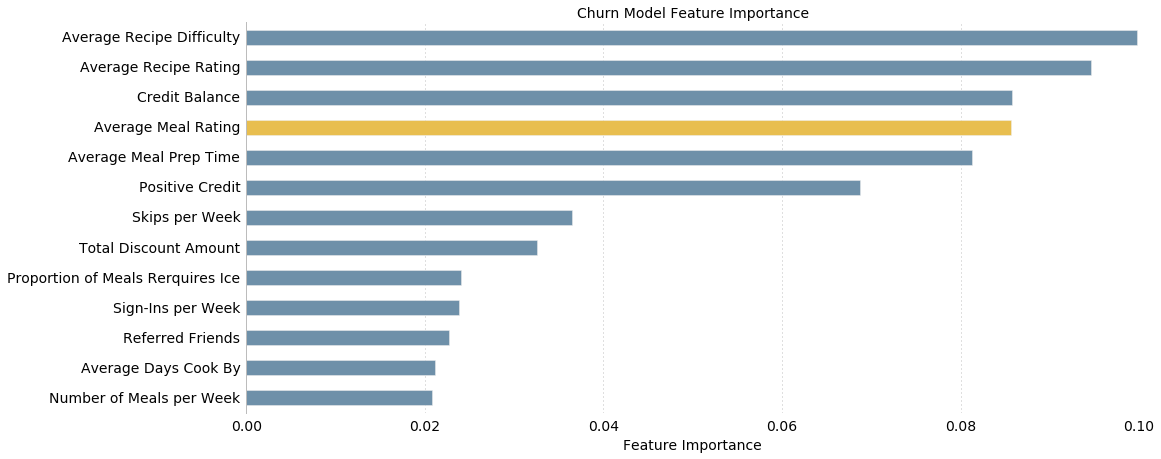

In [36]:
#plot feature importance
all_features = False

rf_features = pd.Series(rf.feature_importances_,index=[pretty_feature_names[h] for h in hazards_domain])

if all_features:
    #plot all values
    plt.rcParams['figure.figsize'] = (16,16)
    imp = rf_features.order()
else:
    #plot only values that are above average
    plt.rcParams['figure.figsize'] = (16, 7)
    imp = rf_features[rf_features>rf_features.mean()].order()
    
colors = highlight_bar(imp,feature)
#highlight the important feature
ax = imp.order().plot(kind='barh',color=colors)
format_chart(ax,horizontal=True,loc=False)
ax.set_title('Churn Model Feature Importance')
ax.set_xlabel('Feature Importance')
plt.rcParams['figure.figsize'] = (16,7)

In [37]:
#why we can't use rothko
test = {'0.000000':0.458599,
'0.540541':0.391597,
'0.810811':0.410157,
'1.071429':0.416984,
'1.363636':0.438069,
'1.666667':0.442299,
'1.992000':0.448384,
'2.307692':0.460602,
'2.727273':0.471646,
'3.112500':0.479964,
'3.750000':0.491855,
'4.285714':0.599843,
'5.000000':0.632696,
'6.666667':0.675968,
'8.333333':0.697830,
'10.000000':0.719832,
'15.000000':0.734984,
'20.000000':0.739480,
'49.750000':0.734176}

t = pd.Series(test)
# rk.plot(t,kind='line')

### Average Meal Rating Has Mixed Impact on Risk of Churn
The following chart shows the results of feature perturbation across our target feature. Feature perturbation holds all other features constant while shifting the value of a single feature. This allows us to estimate the isolated impact of an individual feature on the risk of churn. In the chart below, the higher the change in churn risk, the more likely elements of that feature increase a customer's risk of churn.

The average meal rating a customer experienced ranges from 2 (all meals in a customer's lifetime had low average ratings) to 5 (all meals in a customer's lifetime had high average ratings). The shape of the feature perturbation curve shows a very slow decrease in predicted churn risk as the average rating increases until the moderate point (average rating of 4.0). From moderate to the above moderate point (average rating equals to 4.3) in average meal rating, the curve started a fast decrease in predicted churn risk. The increasing churn risk we see at higher meal ratings at the end of this chart might result from interaction between average meal rating and another feature which is not being captured in this graph.

# Original
### Average Meal Rating Has Mixed Impact on Risk of Churn
The following chart shows the results of feature perturbation across our target feature. Feature perturbation holds all other feature constant while shifting the value of a single feature. This allows us to estimate the isolated impact of an individual feature on the risk of churn. In the chart below, the higher the change in churn risk, the more likely elements of that feature increase a customer's risk of churn.

The average meal rating a customer experienced ranges from 2 (all low ratings in a customer's lifetime) to 5 (all high ratings in a customer's lifetime). The shape of the feature perturbation curve shows a very slow decrease in predicted churn risk as the average rating increases until the moderate point (average rating equals to 4.0). From moderate to the above moderate point (average rating equals to 4.3) in average meal rating, the curve started a fast decrease in predicted churn risk.

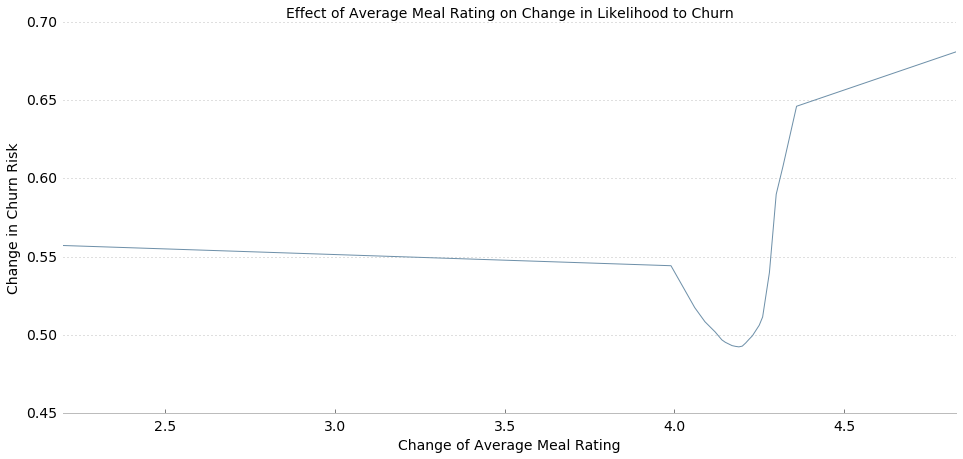

In [38]:
#plot feature perturbation

# ax = md.plot_perturbed_data(feature,bins='default')
# as divisior increases, bin size decreases, range controls how many of the bins are returned.
bins = 'default'
dat = md.perturb_data(feature,bins=bins)

#cardinality to determine plot type
p_type = plot_type(dat)

# if currency_transform:
#     dat.index = dat.index/100
title = "Effect of %s on Change in Likelihood to Churn" %(pretty_feature_names[feature])
xlabel = "Change of %s" %(pretty_feature_names[feature] if not(currency_transform) else pretty_feature_names[feature]+' ($)')
ylabel = "Change in Churn Risk"

ax = dat.plot(kind = p_type, title = title)
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
format_chart(ax,loc=False)
plt.show()

In [39]:
q = "select recipe_rating from reviews where user_id in (select id from users where completed_signup_at is not null) and recipe_rating is not null"
df_meals = sql(q)

transferring from s3


In [40]:
print df_meals.recipe_rating.value_counts(normalize=True)

5    0.521946
4    0.264582
3    0.138883
2    0.046546
1    0.028043
Name: recipe_rating, dtype: float64


/usr/local/lib/python2.7/dist-packages/pandas/tools/plotting.py:929: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"


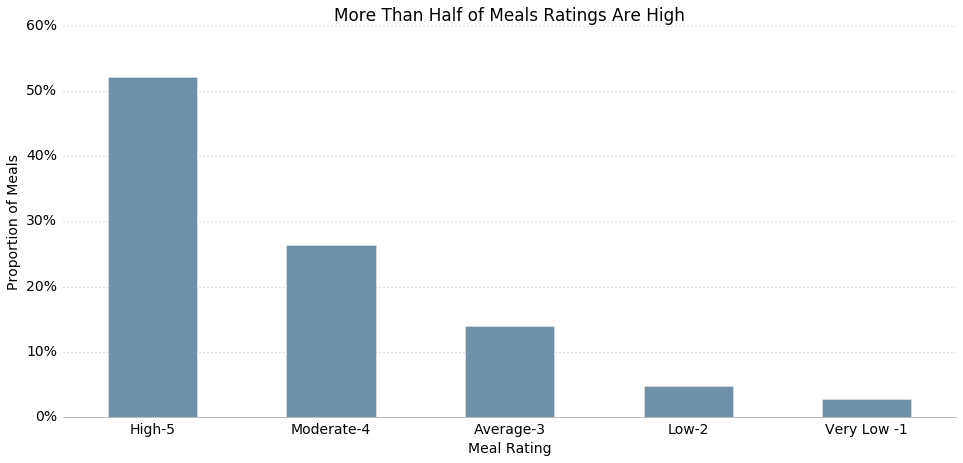

In [41]:
#plot meal difficulty distribution
ax = df_meals.recipe_rating.value_counts(normalize=True).plot(kind='bar',colors=palette[0],rot=0)
format_chart(ax,loc=False)
plt.gca().get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x,p: str(int(x * 100)) + '%'))
ax.set_xticklabels(['High-5','Moderate-4','Average-3','Low-2','Very Low -1'])
ax.set_title('More Than Half of Meals Ratings Are High',size='large')
ax.set_xlabel('Meal Rating')
ax.set_ylabel("Proportion of Meals")
plt.show()

### Interaction Effect

To detect the feature interacting with average meal rating, we look at the tree splits in the random forest model, and which features were selected in the splits near average meal rating. We find that *average difficulty level* potentially interacts with meal rating, causing the stange effect shown above.

To test this, we used logistic regression to specify interactions explicitly and test for their signficance and magnitude. To tease out the effect of the interactor (average difficulty level) we fix it at high and low values, and regress risk of churn on the rest of the features. Then, we look at how the effect of average meal rating changes when we hold difficulty at high versus low value.

Here we find the explanation for the mixed effect. When difficulty level is set low, average meal rating has a negative impact on churn; higher rating lowers risk of churn, as one's intuition would suggest. However, when difficulty is set at a high threshold, the effect on churn is the opposite. This is suggesting that the difficulty level is what is driving risk of churn when the meals are at high average ratings.

In [42]:
train3 = train_norm.copy()
train3['const'] = 1
train3['i2'] = train_norm['avg_difficulty_level']*train_norm['avg_meal_rating']
train3['i3'] = train_norm['prep_avg']*train_norm['avg_meal_rating']

In [43]:
logit_domain = copy(hazard_cols) # Removed biased and almost constant columns. Correlated cols ARE NOT excluded
logit_domain.remove('number_of_baskets')
logit_domain.remove('is_churned')
logit_domain.remove('signInsPerWeek')
logit_domain.remove('has_remaining_credit')
logit_domain.remove('is_.net')
logit_domain.remove('deliver_day_Friday')
logit_domain.remove('voucher_Other')
logit_domain.remove('average_r_rating')

logit_domain.extend([  'i2', 'i3'])
logit_domain.extend(['const'])

In [44]:
# recenter to interpet the slope for interaction
train3['avg_difficulty_level'] =train3['avg_difficulty_level'] - (train3['avg_difficulty_level'].mean() - train3['avg_difficulty_level'].std())
train3['i2'] = train3['avg_difficulty_level']*train3['avg_meal_rating']
logit = sm.Logit(train3.is_churned, train3[logit_domain]) 
result_lo = logit.fit()

train3['avg_difficulty_level'] =train3['avg_difficulty_level'] - (train3['avg_difficulty_level'].mean() + train3['avg_difficulty_level'].std())
train3['i2'] = train3['avg_difficulty_level']*train3['avg_meal_rating']
logit = sm.Logit(train3.is_churned, train3[logit_domain]) 
result_hi = logit.fit()



Optimization terminated successfully.
         Current function value: 0.572425
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.572425
         Iterations 7


In [45]:
coefs = pd.DataFrame(columns=['lo', 'hi'], index=['avg_meal_rating', 'intercept'])

coefs['lo'].ix['avg_meal_rating'] = result_lo.params['avg_meal_rating']
coefs['lo'].ix['intercept'] = result_lo.params['const']

coefs['hi'].ix['avg_meal_rating'] = result_hi.params['avg_meal_rating']
coefs['hi'].ix['intercept'] = result_hi.params['const']
coefs

,lo,hi
avg_meal_rating,-0.058914,0.212141
intercept,-0.231169,0.190615


In [46]:
print np.exp(coefs['lo'][0]+coefs['lo'][1]) #lo difficulty lowers risk
print np.exp(coefs['hi'][0]+coefs['hi'][1]) #hi high difficulty increases risk

0.748201291078
1.49594122041


In [47]:
# train4 = train_norm.copy()
# train4['const'] = 1
# train4['i2'] = train_norm['avg_difficulty_level']*train_norm['avg_meal_rating']
# train4['i3'] = train_norm['prep_avg']*train_norm['avg_meal_rating']

# train4['prep_avg'] =train4['prep_avg'] - (train4['prep_avg'].mean() - train4['prep_avg'].std())
# train4['i3'] = train4['prep_avg']*train4['avg_meal_rating']
# logit = sm.Logit(train3.is_churned, train3[logit_domain]) 
# result_lo_prep = logit.fit()

# train4['prep_avg'] =train4['prep_avg'] - (train4['prep_avg'].mean() + train4['prep_avg'].std())
# train4['i3'] = train4['prep_avg']*train4['prep_avg']
# logit = sm.Logit(train4.is_churned, train4[logit_domain]) 
# result_hi_prep = logit.fit()

# coefs_prep = pd.DataFrame(columns=['lo', 'hi'], index=['prep_avg', 'intercept'])

# coefs_prep['lo'].ix['prep_avg'] = result_lo_prep.params['prep_avg']
# coefs_prep['lo'].ix['intercept'] = result_lo_prep.params['const']

# coefs_prep['hi'].ix['prep_avg'] = result_hi_prep.params['prep_avg']
# coefs_prep['hi'].ix['intercept'] = result_hi_prep.params['const']
# coefs_prep

# print np.exp(coefs_prep['lo'][0]+coefs_prep['lo'][1]) #lo difficulty lowers risk
# print np.exp(coefs_prep['hi'][0]+coefs_prep['hi'][1]) #hi high difficulty increases risk

In [48]:
effects = pd.DataFrame(columns=['Low', 'High'])
effects['Low'] = pd.Series(np.exp(coefs['lo'][0]+coefs['lo'][1])-1)
effects['High'] =  pd.Series(np.exp(coefs['hi'][0]+coefs['hi'][1])-1)
print effects

        Low      High
0 -0.251799  0.495941


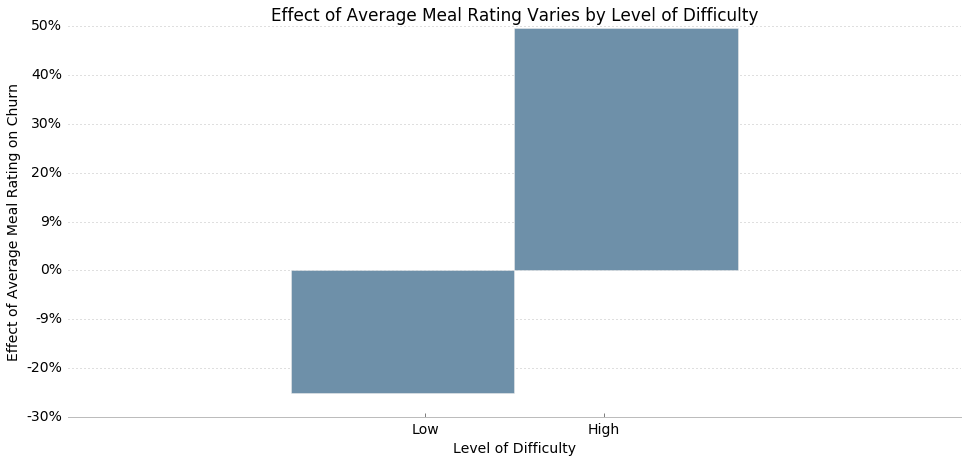

In [49]:
# bar plot
ax = effects.plot(kind='bar',colors=palette[0],rot=0)

format_chart(ax,loc=False)
plt.gca().get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x,p: str(int(x * 100)) + '%'))
ax.set_xticks([-0.1,0.1])
ax.set_xticklabels(['Low', 'High'])
ax.set_title('Effect of Average Meal Rating Varies by Level of Difficulty',size='large')
ax.set_xlabel('Level of Difficulty')
ax.set_ylabel("Effect of Average Meal Rating on Churn")
ax.legend_.remove()
plt.show()

### Distribution of Average Meal Rating

Roughly 95% of all customers experienced ratings somewhere between all moderate (average meal rating equals to 4.0) and all above moderate (average meal rating equals to 4.5). 

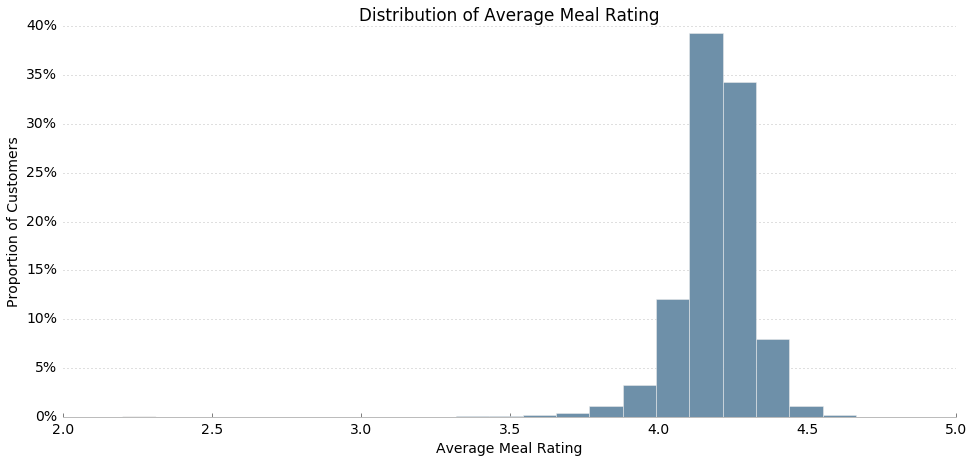

In [50]:
#plot histogram of feature in HC data

#change this value manually if you'd like different binning
if currency_transform:
    feature_data = modeling_data[feature]/100
else:
    feature_data = modeling_data[feature]

bins = bins_suggestion(feature_data)

xlabel = pretty_feature_names[feature]+' ($)' if currency_transform else pretty_feature_names[feature]
ylabel = "Proportion of Customers"
title = "Distribution of %s"%(pretty_feature_names[feature])

weights = np.ones_like(feature_data)/float(len(feature_data))
ax = feature_data.hist(bins=bins,weights=weights)
format_chart(ax,loc=False)
ax.set_title(title,size='large')
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
#optional chart parameters follow
plt.gca().get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x,p: str(int(x * 100)) + '%'))
plt.show()

Over time, average meal rating remained somewhat consitent throughout 2015. We see a decrease in average meal ratings around February 2015 when the rating system change took place. The light band around the series shows the 95% confidence interval. Note that the findings above do not change whether we include or exclude the time period after the system change from the model.

# Optional Fourth Plot

This chart exists to help explain any other fundamentally important phenomenon in the data or the perturbations. Or this space could be used to preempt a question a customer may ask based on the information above.

In [51]:
# cell: connection
conn = psycopg2.connect(
   database='homechef',
   port=os.environ['REDSHIFT_PORT'],
   password=os.environ['REDSHIFT_PASS'],
   user=os.environ['REDSHIFT_USER'],
   host=os.environ['REDSHIFT_HOST']
  ) 

In [52]:
#cell: function to use @cache capability
@cache()
def query(query,conn) :
    """
    Perform a redshift query and return the results 
    """
    return pd.read_sql(query,conn)

In [53]:
#cell: 
query1 = """
SELECT DATE_TRUNC('day',created_at) AS date_day,
       AVG(recipe_rating) AS meal_rating,
       COUNT(*) as t
FROM reviews
WHERE DATE_TRUNC('day',created_at) > '2015-02-04'
AND DATE_TRUNC('day',created_at) <= '2016-05-12'
AND user_id IN (SELECT id FROM users WHERE completed_signup_at IS NOT NULL)
GROUP BY 1
ORDER BY date_day
"""
mean_ratings_by_date=pd.read_sql(query1,conn)
print len(mean_ratings_by_date)
mean_ratings_by_date.head()

401


,date_day,meal_rating,t
0,2015-04-08,4.34,148
1,2015-04-09,4.25,215
2,2015-04-10,4.42,493
3,2015-04-11,4.21,150
4,2015-04-12,4.12,181


In [54]:
# set index
mean_ratings_by_date = mean_ratings_by_date.set_index(['date_day'])
mean_ratings_by_date.head(2)

,meal_rating,t
date_day,,
2015-04-08,4.34,148
2015-04-09,4.25,215


In [55]:
#cell: 
query2 = """
SELECT DATE_TRUNC('week',created_at) AS date_week,
       AVG(recipe_rating) AS meal_rating,
       STDDEV_SAMP(recipe_rating) AS std_dev,
       COUNT(*) as t
FROM reviews
WHERE DATE_TRUNC('week',created_at) > '2015-02-04'
AND DATE_TRUNC('week',created_at) < '2016-05-09'
AND user_id IN (SELECT id FROM users WHERE completed_signup_at IS NOT NULL)
GROUP BY 1
ORDER BY date_week
"""
mean_ratings_by_week=pd.read_sql(query2,conn)

In [56]:
# set index 
mean_ratings_by_week = mean_ratings_by_week.set_index(['date_week'])
mean_ratings_by_week.head(2)

,meal_rating,std_dev,t
date_week,,,
2015-04-06,4.31,0.978185,1187
2015-04-13,4.11,1.088476,1480


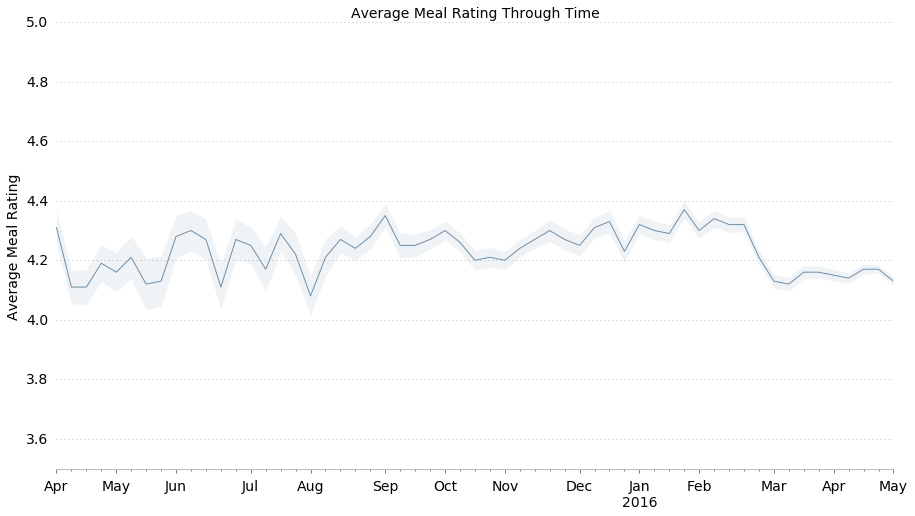

In [60]:
plt.rcParams['figure.figsize'] = [15,8]
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'


ax1 = mean_ratings_by_week['meal_rating'].plot()
ax1.fill_between( mean_ratings_by_week.index
                 ,mean_ratings_by_week['meal_rating']+ 1.96*mean_ratings_by_week['std_dev']/np.sqrt(mean_ratings_by_week['t'])
                 ,mean_ratings_by_week['meal_rating']- 1.96*mean_ratings_by_week['std_dev']/np.sqrt(mean_ratings_by_week['t'])
                 , facecolor = colors[0]
                 , alpha = 0.1)
blues = ['#4292c6','#2171b5','#08519c','#08306b', 'black', '#6baed6']

ax1.grid(b = False)

box1 = ax1.get_position()
ax1.set_position([box1.x0, box1.y0, box1.width, box1.height])
ax1.set_ylabel('Average Meal Rating')
ax1.set_xlabel('')
ax1.set_ylim([3.5, 5])


plt.title('Average Meal Rating Through Time')
format_chart(plt.gca(),loc=False)
plt.show()


In [58]:
# rk plot
rk.plot(mean_ratings_by_week.meal_rating,
        kind='line',
        xlabel='Weekly',
        ylabel='Average Meal Ratings', ylim=[3.5, 5])

### Impact and Further Opportunity

When difficulty level is held low, average meal rating has a negative impact on churn, and higher rating lowers risk of churn. However, the average rating of meal shows some level of interaction with difficulty of the meal. While most of Home Chef's meal are easy to moderate, it is important to recognize the difficulty level as one of the highest-impact factors on churn. Bearing this in mind, higher-rated meals with lower difficulties are likely to reduce churn. Any meals that meet both of these criteria should be examined closely, and future analyses can explore the potential gains in marketing these meals to customers.